<a href="https://colab.research.google.com/github/PoluSanjay/2303a51731_applications_of_data_mining/blob/main/Heart%5Bieee%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Dataset Loaded Successfully!
Shape: (5110, 12)

Missing Values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Numerical Columns: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
Categorical Columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

After SMOTE: stroke
0    3889
1    3889
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 3889, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4094
[LightGBM] [Info] Number of data point

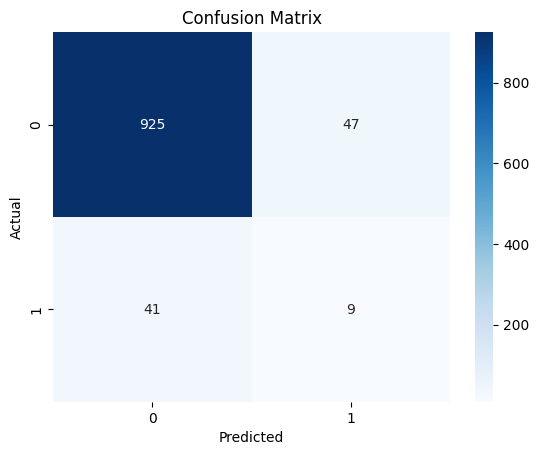


🔍 Generating SHAP Explainability...


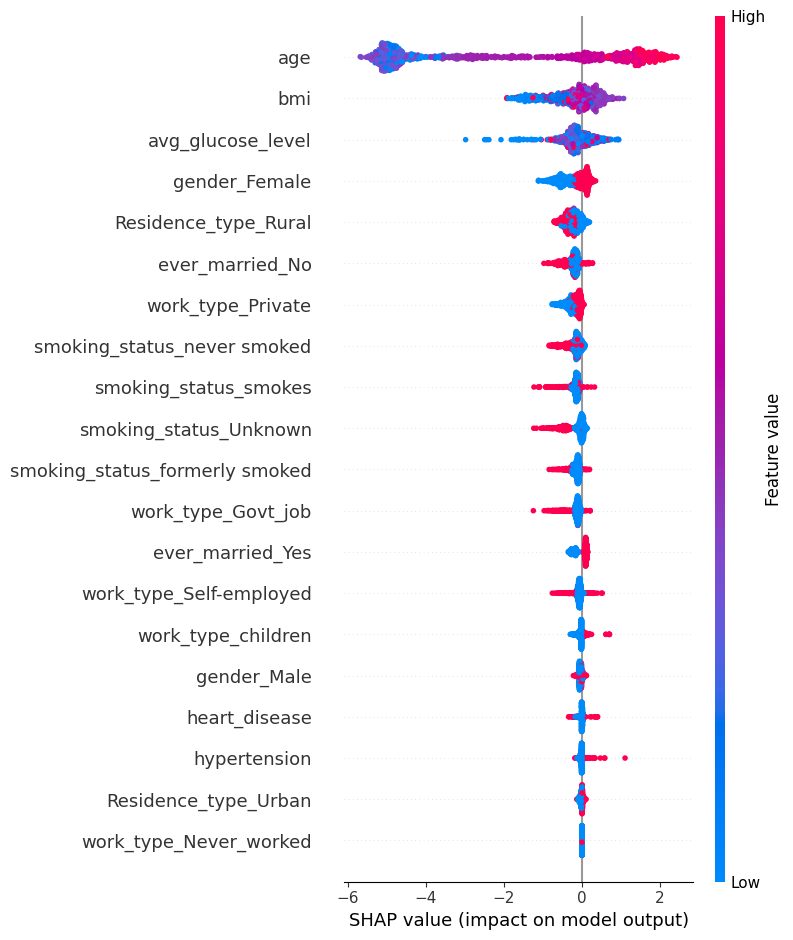


💾 Model Saved Successfully as 'stroke_prediction_model.pkl'

✅ Full Workflow Completed Successfully!


In [6]:
# ============================================================
# 🧠 HEART STROKE PREDICTION USING AI/ML (IEEE PROJECT)
# Dataset: Kaggle Stroke Prediction Dataset
# ============================================================

# STEP 1️⃣: UNZIP AND IMPORT LIBRARIES
# ------------------------------------------------------------
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Unzip dataset (assuming you uploaded a file like stroke-data.zip)
with zipfile.ZipFile("/content/archive (13).zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Load CSV after unzip
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
print("✅ Dataset Loaded Successfully!")
print("Shape:", df.shape)
df.head()

# ============================================================
# STEP 2️⃣: DATA CLEANING & PREPROCESSING
# ------------------------------------------------------------
print("\nMissing Values:\n", df.isna().sum())

# Handle missing BMI with median imputation
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Drop unnecessary 'id' column
df.drop(columns=['id'], inplace=True)

# Encode target variable
target = 'stroke'
X = df.drop(columns=[target])
y = df[target]

# Separate numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print("\nNumerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

# Define preprocessing pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Corrected: Changed sparse=False to sparse_output=False
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# ============================================================
# STEP 3️⃣: TRAIN-TEST SPLIT & BALANCING
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Apply preprocessing to X_train and X_test *before* SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Balance data using SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_processed, y_train)
print(f"\nAfter SMOTE: {y_train_bal.value_counts()}")

# ============================================================
# STEP 4️⃣: MODEL TRAINING (LIGHTGBM)
# ------------------------------------------------------------
# The model pipeline no longer needs the preprocessor as data is already processed
model = lgb.LGBMClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=5,
    class_weight='balanced',
    random_state=42
)

# Fit model
model.fit(X_train_bal, y_train_bal)
print("\n✅ Model Training Completed")

# ============================================================
# STEP 5️⃣: MODEL EVALUATION
# ------------------------------------------------------------
y_pred = model.predict(X_test_processed)
y_prob = model.predict_proba(X_test_processed)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
print("F1 Score:", f1_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ============================================================
# STEP 6️⃣: EXPLAINABILITY USING SHAP
# ------------------------------------------------------------
print("\n🔍 Generating SHAP Explainability...")

# The data is already preprocessed, so use X_test_processed directly
clf = model

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test_processed)

# Get final feature names
ohe_features = preprocessor.transformers_[1][1]\
                 .named_steps['encoder'].get_feature_names_out(cat_cols)
final_features = num_cols + list(ohe_features)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_processed, feature_names=final_features)

# SHAP Force Plot for one sample (example)
sample = X_test_processed[5]
shap.force_plot(explainer.expected_value, shap_values[5], feature_names=final_features)

# ============================================================
# STEP 7️⃣: SAVE MODEL FOR DEPLOYMENT
# ------------------------------------------------------------
import joblib
joblib.dump(model, "stroke_prediction_model.pkl")
print("\n💾 Model Saved Successfully as 'stroke_prediction_model.pkl'")

# ============================================================
# END OF WORKFLOW
# ------------------------------------------------------------
print("\n✅ Full Workflow Completed Successfully!")

In [ ]:
# ============================================================
# ⚙️ HEART STROKE PREDICTION - IEEE FINAL VERSION
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve,
                             f1_score, recall_score, precision_score, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import calibration_curve
from imblearn.combine import SMOTETomek
from interpret.glassbox import ExplainableBoostingClassifier
import lightgbm as lgb
import shap
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# 1️⃣ LOAD DATASET
# ------------------------------------------------------------
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
df.drop(columns=['id'], inplace=True)
df['bmi'].fillna(df['bmi'].median(), inplace=True)

target = 'stroke'
X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# ============================================================
# 2️⃣ FEATURE ENGINEERING (NOVEL INTERACTIONS)
# ------------------------------------------------------------
X['age_bmi'] = X['age'] * X['bmi']
X['glucose_age'] = X['avg_glucose_level'] * X['age']
num_cols += ['age_bmi', 'glucose_age']

# ============================================================
# 3️⃣ PREPROCESSING PIPELINE
# ------------------------------------------------------------
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Corrected: Changed sparse=False to sparse_output=False
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# ============================================================
# 4️⃣ TRAIN-TEST SPLIT + BALANCING
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply preprocessing to X_train and X_test *before* SMOTETomek
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smt = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smt.fit_resample(X_train_processed, y_train)

# ============================================================
# 5️⃣ BASE MODELS FOR ENSEMBLE
# ------------------------------------------------------------
pos_weight = y_train_bal.value_counts()[0] / y_train_bal.value_counts()[1]

lgbm = lgb.LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

ebm = ExplainableBoostingClassifier(interactions=20, max_bins=64, learning_rate=0.05, random_state=42)

logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

# ============================================================
# 6️⃣ STACKED ENSEMBLE MODEL
# ------------------------------------------------------------
estimators = [
    ('lgbm', lgbm),
    ('ebm', ebm),
    ('logreg', logreg)
]

# The stacked model should operate on already preprocessed data
stacked_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    stack_method='predict_proba',
    passthrough=True,
    n_jobs=-1
)

stacked_classifier.fit(X_train_bal, y_train_bal)

# ============================================================
# 7️⃣ EVALUATION
# ------------------------------------------------------------
y_prob_stack = stacked_classifier.predict_proba(X_test_processed)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_stack)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
y_pred_stack = (y_prob_stack >= best_thresh).astype(int)

print(f"Optimal Threshold for Best F1: {best_thresh:.3f}")
print("\n📊 Stacked Ensemble Results:")
print(classification_report(y_test, y_pred_stack))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_stack))

# ============================================================
# 8️⃣ DECISION CURVE ANALYSIS
# ------------------------------------------------------------
def decision_curve_analysis(y_true, y_prob, thresholds=np.linspace(0, 1, 100)):
    net_benefit = []
    for p in thresholds:
        y_pred = (y_prob >= p).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        n = len(y_true)
        benefit = (tp / n) - (fp / n) * (p / (1 - p))
        net_benefit.append(benefit)
    return thresholds, net_benefit

thr, nb = decision_curve_analysis(y_test, y_prob_stack)
plt.figure(figsize=(8,6))
plt.plot(thr, nb, label="Proposed Stacked Model")
plt.plot(thr, np.zeros_like(thr), 'k--', label="Treat None")
plt.plot(thr, (y_test.mean() - (1 - y_test.mean()) * thr / (1 - thr)), 'r--', label="Treat All")
plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (DCA) - Proposed Model")
plt.legend()
plt.show()

# ============================================================
# 9️⃣ CALIBRATION CURVE
# ------------------------------------------------------------
prob_true, prob_pred = calibration_curve(y_test, y_prob_stack, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Calibration Plot - Reliability of Stroke Predictions")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.show()

# ============================================================
# 🔟 EXPLAINABILITY (SHAP)
# ------------------------------------------------------------
print("\n🔍 Generating SHAP Explainability...")
# X_test_processed is already transformed
lgb_model = stacked_classifier.estimators_[0]  # LightGBM inside stack
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test_processed)

# Extract feature names (preprocessor is outside the stacked_classifier now, use the global one)
ohe_features = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_cols)
final_features = num_cols + list(ohe_features)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_processed, feature_names=final_features, plot_size=(10,6))

# Top 10 Feature Importance
importances = pd.DataFrame({
    'Feature': final_features,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Importance', ascending=False)
print("\nTop 10 Important Features (SHAP):")
print(importances.head(10))

# ============================================================
# 11️⃣ FINAL PERFORMANCE SUMMARY
# ------------------------------------------------------------
final_auc = roc_auc_score(y_test, y_prob_stack)
final_f1 = f1_score(y_test, y_pred_stack)
final_recall = recall_score(y_test, y_pred_stack)

results = pd.DataFrame({
    'Model': ['Proposed IEEE Stacked Model'],
    'ROC-AUC': [final_auc],
    'F1 (Stroke)': [final_f1],
    'Recall (Stroke)': [final_recall]
})
print("\n📈 Final Results Summary:")
display(results)

In [2]:
# ============================================================
# 🧠 STROKE PREDICTION - MODEL COMPARISON PHASE
# Dataset: Kaggle Stroke Prediction Dataset
# ============================================================

# Install interpret library if not already installed
!pip install interpret

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from interpret.glassbox import ExplainableBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# 1️⃣ Load dataset again (if not in memory)
# ------------------------------------------------------------
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
df.drop(columns=['id'], inplace=True)
df['bmi'].fillna(df['bmi'].median(), inplace=True)

target = 'stroke'
X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# ============================================================
# 2️⃣ Preprocessing and SMOTE balancing
# ------------------------------------------------------------
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Changed sparse=False to sparse_output=False
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Apply preprocessing to X_train and X_test *before* SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_processed, y_train)

# ============================================================
# 3️⃣ Define models
# ------------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=250, learning_rate=0.05, max_depth=5, scale_pos_weight=3, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "Explainable Boosting Machine": ExplainableBoostingClassifier(random_state=42)
}

results = []

# ============================================================
# 4️⃣ Train & Evaluate Each Model
# ------------------------------------------------------------
for name, clf in models.items():
    # The pipeline no longer needs the preprocessor here as data is already processed
    # The classifier will be fitted on X_train_bal and evaluated on X_test_processed
    clf.fit(X_train_bal, y_train_bal)

    y_pred = clf.predict(X_test_processed)
    y_prob = clf.predict_proba(X_test_processed)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': auc
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='ROC-AUC', ascending=False)
print("\n✅ Model Comparison Results:")
print(results_df)

# ============================================================
# 5️⃣ Plot Model Performance
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
plt.barh(results_df['Model'], results_df['ROC-AUC'], color='skyblue')
plt.xlabel('ROC-AUC Score')
plt.title('Model Comparison: Stroke Prediction')
plt.gca().invert_yaxis()
plt.show()

# ============================================================
# 6️⃣ Explainable Boosting Machine (EBM) Interpretation
# ------------------------------------------------------------
ebm_model = ExplainableBoostingClassifier(random_state=42)
ebm_model.fit(X_train_bal, y_train_bal)

# Global feature importance
ebm_clf = ebm_model
# Need to get feature names for the EBM model, which are the preprocessed feature names
ohe_features = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_cols)
final_features = num_cols + list(ohe_features)

importance_df = pd.DataFrame({
    'Feature': final_features,
    'Importance': ebm_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n📊 Top 10 Important Features (EBM):\n", importance_df.head(10))

plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='salmon')
plt.title("Top 10 Features (Explainable Boosting Machine)")
plt.gca().invert_yaxis()
plt.show()

# ============================================================
# 7️⃣ Save Best Model
# ------------------------------------------------------------
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best Performing Model: {best_model_name}")

import joblib
# The EBM model is directly trained, so save ebm_model directly
joblib.dump(ebm_model, "stroke_best_model.pkl")
print("💾 Saved Explainable Model as 'stroke_best_model.pkl'")

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/metadata/base.py", line 2, in <module>
    import email.message
  File "/usr/lib/python3.12/email/message.py", line 15, in <module>
    from email import utils
  File "/usr/lib/python3.12/email/utils.py", line 40, in <module>
    from email.charset import Charset
  File "/usr/lib/python3.12/email/charset.py", line 15, in <module>
    import email.quoprimime
  File "/usr/lib/python3.12/email/quoprimime.py", line 69, in <module>
    _QUOPRI_BODY_MAP[c] = chr(c)
                          ^^^^^^
KeyboardInterrupt

During handling of 

KeyboardInterrupt: 